Processing file: https://analyse.hfm-weimar.de/database/02/PrJode_Jos0302_COM_1-5_MissaDapac_002_00006.xml




,Measure,Local Onset,Duration,Pitch,MIDI
0,1,0.0,8.0,G3,55
1,1,8.0,4.0,F3,53
2,2,12.0,8.0,G4,67
3,2,12.0,3.0,G3,55
4,2,15.0,1.0,A3,57
...,...,...,...,...,...
792,63,667.0,1.0,E4,64
793,64,668.0,12.0,G4,67
794,64,668.0,12.0,D4,62
795,64,668.0,12.0,G3,55


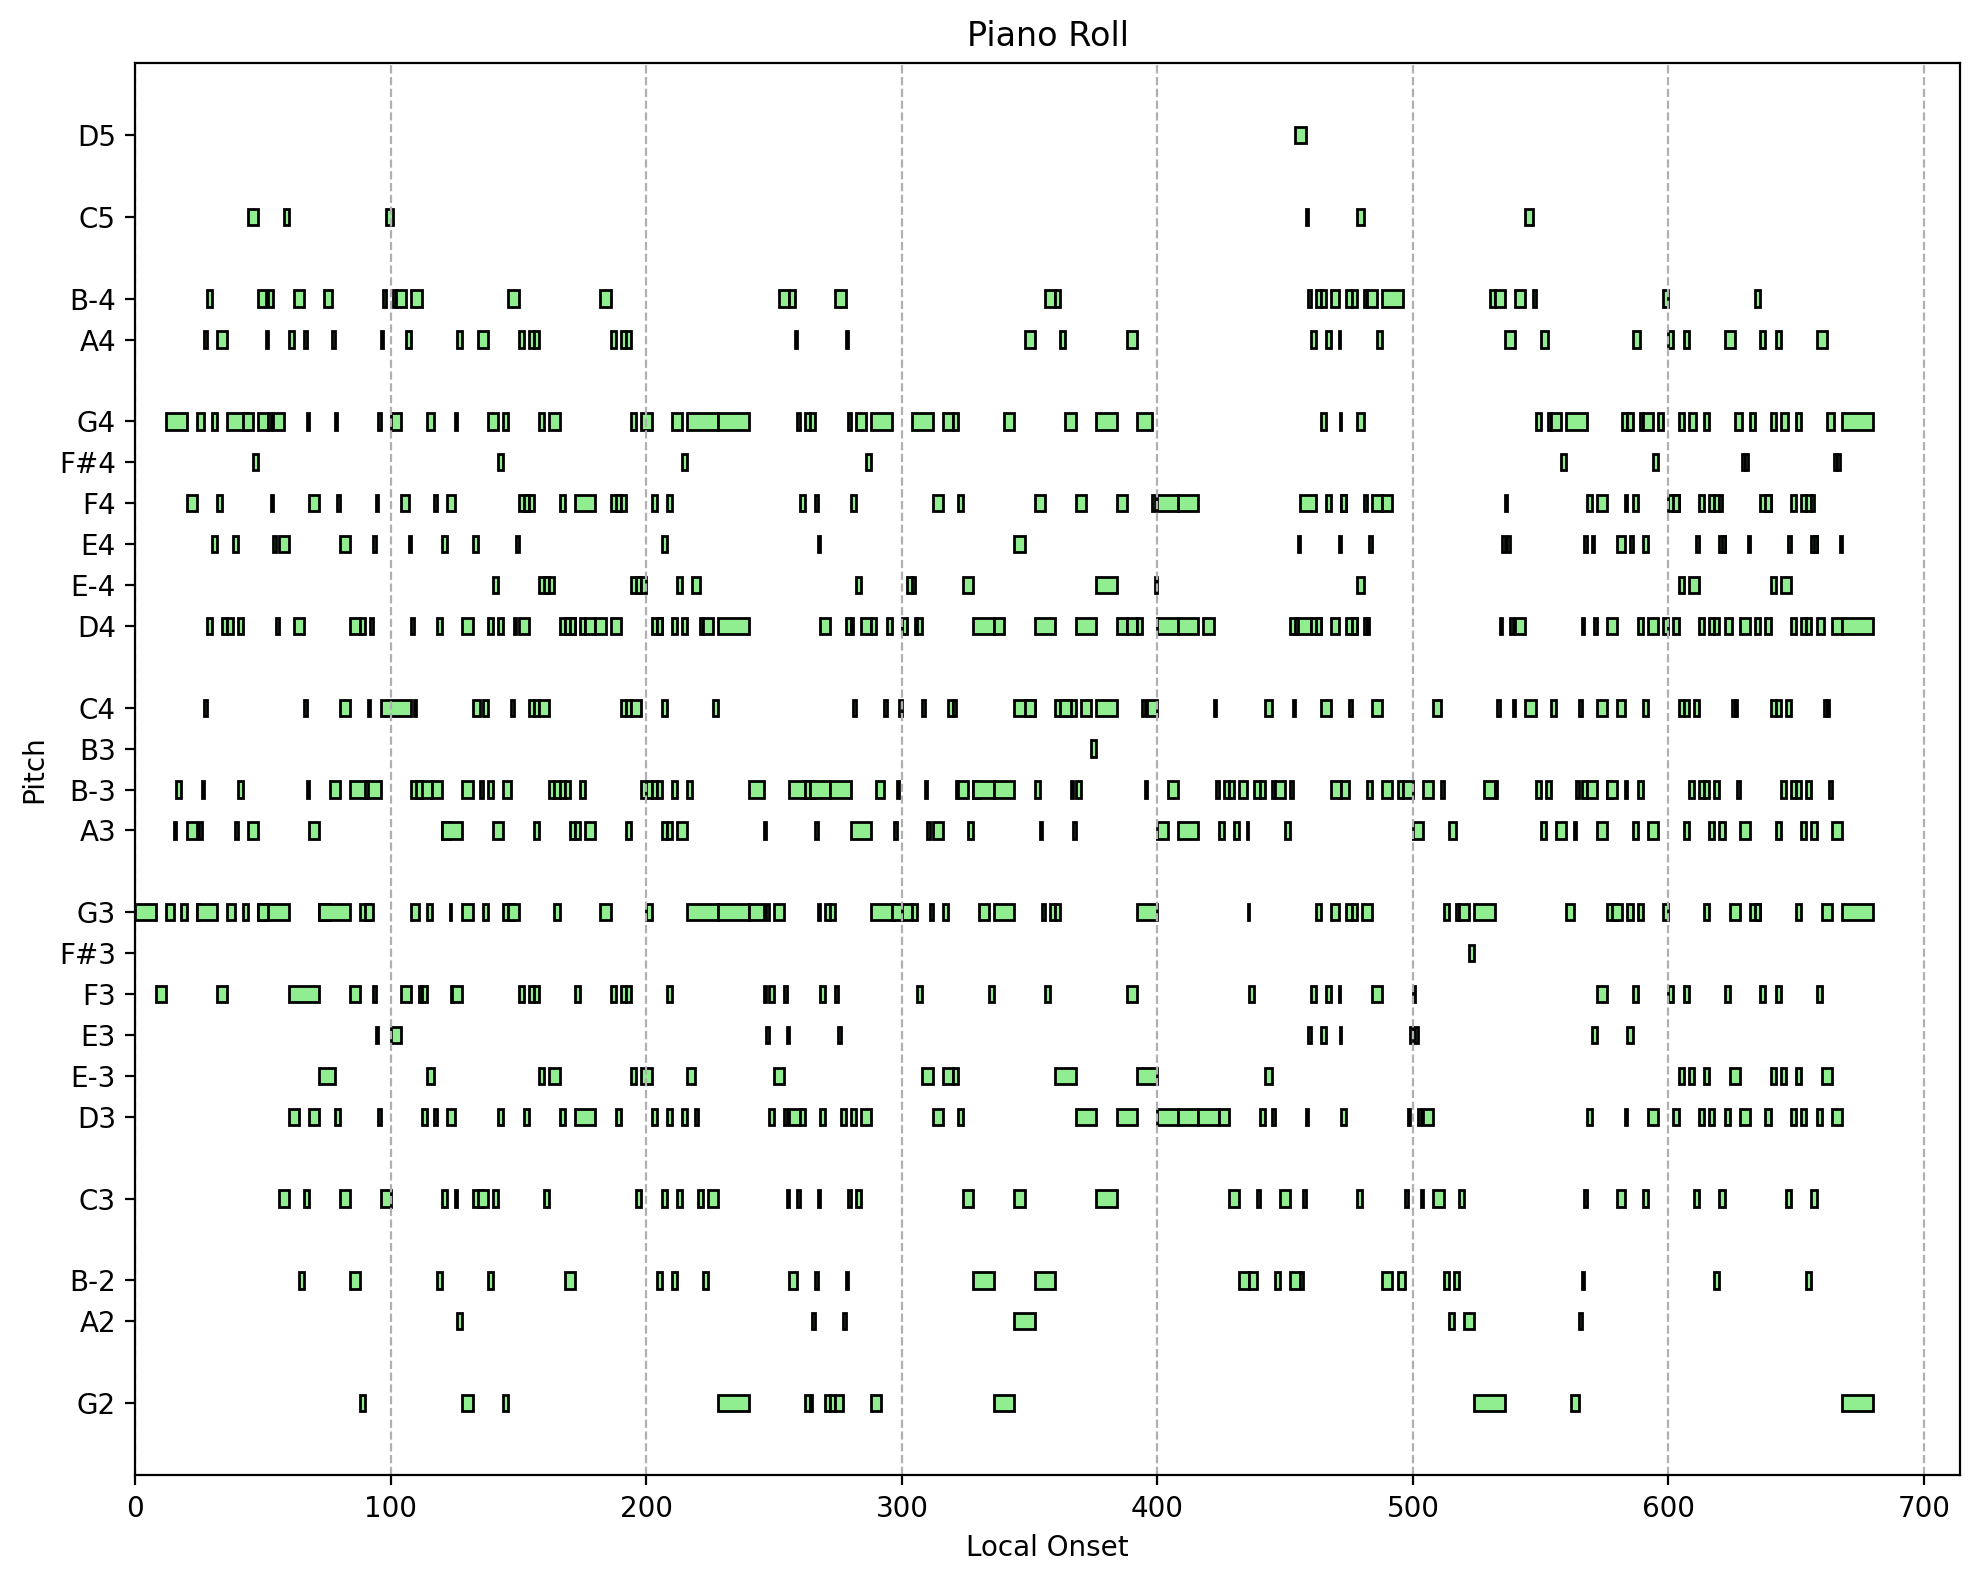

In [1]:
from music21 import converter, note, chord
from music21 import pitch as pitch_module
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tempfile
import os

def get_file_path(file_source):
    """
    Determines the nature of the file_source (URL or local path). If it's a URL, the content is
    downloaded and saved to a temporary file, whose path is returned. If a local path, it verifies
    the file exists and returns the path.

    Parameters
    ----------
    file_source : str
        The source of the file, either a URL or a local file path.

    Returns
    -------
    str
        The path to the local file.

    Raises
    ------
    ValueError
        If there is an error downloading the file from a URL.
    FileNotFoundError
        If the specified local file does not exist.
    """
    if file_source.startswith(('http://', 'https://')):
        try:
            with requests.get(file_source) as response:
                response.raise_for_status()
                _, file_extension = os.path.splitext(file_source)
                with tempfile.NamedTemporaryFile(delete=False, suffix=file_extension) as temp_file:
                    temp_file.write(response.content)
                    return temp_file.name
        except requests.RequestException as e:
            raise ValueError(f"Error downloading the file: {e}")
    else:
        if os.path.exists(file_source):
            return file_source
        else:
            raise FileNotFoundError("Local file does not exist")

def extract_voice_data(score):
    """
    Extracts and aggregates note and chord information from a music21 score object. For chords,
    each constituent note is treated individually.

    Parameters
    ----------
    score : music21.stream.Score
        The music21 score object from which to extract note and chord information.

    Returns
    -------
    list of tuple
        A list of tuples, each containing measure number, position within measure, duration in
        quarter lengths, and pitch as a string.
    """
    voice_data = []
    notes_and_chords = score.flatten().notesAndRests.stream()

    for element in notes_and_chords:
        if isinstance(element, (note.Note, chord.Chord)):
            measure_num = element.measureNumber
            position_within_measure = element.offset
            duration = element.duration.quarterLength
            pitches = [str(element.pitch)] if isinstance(element, note.Note) else [str(p) for p in element.pitches]
            voice_data.extend([(measure_num, position_within_measure, duration, pitch) for pitch in pitches])

    return voice_data

def create_piano_roll(df):
    """
    Creates a piano roll visualization from a DataFrame containing musical note data. This version
    ensures that the y-axis labels match the number of MIDI pitch values present in the DataFrame,
    addressing the previous mismatch issue.

    Parameters
    ----------
    df : pandas.DataFrame
        A DataFrame with columns 'Measure', 'Local Onset', 'Duration', 'Pitch', and 'MIDI',
        containing musical note data for plotting.
    """
    # Generate a consistent pitch name for each MIDI value to ensure matching tick labels
    midi_to_pitch = {midi: pitch for midi, pitch in zip(df['MIDI'], df['Pitch'])}
    
    plt.figure(figsize=(10, 8))
    for index, row in df.iterrows():
        plt.barh(row['MIDI'], width=row['Duration'], left=row['Local Onset'], height=0.4, color='lightgreen', edgecolor='black')
    
    # Use the consistent MIDI to pitch mapping for labeling
    plt.yticks(list(midi_to_pitch.keys()), list(midi_to_pitch.values()))
    plt.xlabel('Local Onset')
    plt.ylabel('Pitch')
    plt.title('Piano Roll')
    plt.grid(True, axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()



def filter_and_adjust_durations(df, filter_zero_duration=True, adjust_fractional_duration=True):
    """
    Filters out notes with 0 duration and adjusts fractional durations in the DataFrame. 
    Also ensures 'Duration' and 'Local Onset' are converted to floats for JSON serialization.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to process.
    filter_zero_duration : bool, optional
        If True, filters out notes with 0 duration. Default is True.
    adjust_fractional_duration : bool, optional
        If True, rounds fractional durations to the nearest whole number. Default is True.

    Returns
    -------
    pandas.DataFrame
        The processed DataFrame.
    """
    # Create a copy to avoid modifying the original DataFrame directly
    df_processed = df.copy()

    if filter_zero_duration:
        df_processed = df_processed[df_processed['Duration'] > 0]

    if adjust_fractional_duration:
        df_processed['Duration'] = pd.to_numeric(df_processed['Duration'], errors='coerce').round(3)
        df_processed['Local Onset'] = pd.to_numeric(df_processed['Local Onset'], errors='coerce').round(3)

    return df_processed


filter_zero_duration = True  # Set to False if you want to keep notes with 0 duration (grace notes)
adjust_fractional_duration = True  # Set to False if you want to keep fractional durations as is

# Define a list or dictionary of file sources.

file_sources = [
    #'https://raw.githubusercontent.com/WolfgangDrescher/lassus-geistliche-psalmen/master/kern/08-domine-dominus-noster.krn',
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_4.0/Music/Complete_examples/Chopin_Etude_Op10_No9.mei'
    #'https://raw.githubusercontent.com/music-encoding/sample-encodings/main/MEI_5.0/Music/Complete_examples/Bach-JS_Ein_feste_Burg.mei'
    'https://analyse.hfm-weimar.de/database/02/PrJode_Jos0302_COM_1-5_MissaDapac_002_00006.xml'
    #'liszt.mxl'
]

try:
    for file_source in file_sources:
        print(f"Processing file: {file_source}")
        print("\n") 
        file_path = get_file_path(file_source)
        score = converter.parse(file_path)
        voice_data = extract_voice_data(score)
        df = pd.DataFrame(voice_data, columns=['Measure', 'Local Onset', 'Duration', 'Pitch'])
        
                # Apply MIDI Pitch Conversion with Error Handling
        try:
            df['MIDI'] = df['Pitch'].apply(lambda x: pitch_module.Pitch(x).midi)
        except Exception as e:
            print(f"Error converting pitch to MIDI: {e}")
            continue
        
        # Process the DataFrame to adjust durations and convert data types
        df_processed = filter_and_adjust_durations(df, filter_zero_duration, adjust_fractional_duration)
        
        # Display the processed DataFrame. Adjust if not applicable for your environment.
        display(df_processed)  # Make sure to use df_processed
        
        create_piano_roll(df_processed)  # Ensure to pass the processed DataFrame
        
        # Break after the first successful execution to prevent processing all file sources.
        break

except Exception as e:
    print(f"An error occurred: {e}")


In [8]:
pd.set_option('display.max_rows', 50)

display(df_processed)

,Measure,Local Onset,Duration,Pitch,MIDI,Adjusted Onset
0,1,0.0,8.0,G3,55,4.0
1,1,8.0,4.0,F3,53,10.0
2,2,12.0,8.0,G4,67,16.0
3,2,12.0,3.0,G3,55,13.5
4,2,15.0,1.0,A3,57,15.5
...,...,...,...,...,...,...
792,63,667.0,1.0,E4,64,667.5
793,64,668.0,12.0,G4,67,674.0
794,64,668.0,12.0,D4,62,674.0
795,64,668.0,12.0,G3,55,674.0


In [3]:
# Matplotlibs interactive mode

%matplotlib qt5

create_piano_roll(df_processed) 

In [4]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, FactorRange
import pandas as pd

def midi_to_pitch(midi):
    """ Converts MIDI note number to pitch notation. """
    notes = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    octave = (midi // 12) - 1
    note_index = midi % 12
    return f"{notes[note_index]}{octave}"

def create_piano_roll_bokeh(df):
    # Determine the minimum and maximum MIDI values
    min_midi = df['MIDI'].min()
    max_midi = df['MIDI'].max()
    
    # Generate the pitch range based on min/max MIDI values
    pitch_range = [midi_to_pitch(midi) for midi in range(min_midi, max_midi + 1)]
    
    # Create a ColumnDataSource from DataFrame
    source = ColumnDataSource(df)
    
    # Create the figure with correct dimensions and limited pitch range
    p = figure(title="Piano Roll - Bokeh", x_axis_label='Local Onset', y_axis_label='Pitch',
               height=500, width=1000, y_range=FactorRange(factors=pitch_range), tools="pan,wheel_zoom,box_zoom,reset")
    
    # Adjust x for left alignment by subtracting half the width
    df['Adjusted Onset'] = df['Local Onset'] + df['Duration'] / 2
    
    # Update source with adjusted DataFrame
    source.data = df
    
    # Plot rectangles for notes
    p.rect(x='Adjusted Onset', y='Pitch', width='Duration', height=0.8, source=source,
           color="lightgreen", line_color='black')
    
    # Configuring additional options
    p.ygrid.grid_line_color = None
    p.xgrid.grid_line_color = 'gray'
    p.xgrid.grid_line_dash = [6, 4]
    
    # Display the plot inline in Jupyter Notebook
    output_notebook()
    show(p)

# Example usage
create_piano_roll_bokeh(df_processed)


Loading BokehJS ...

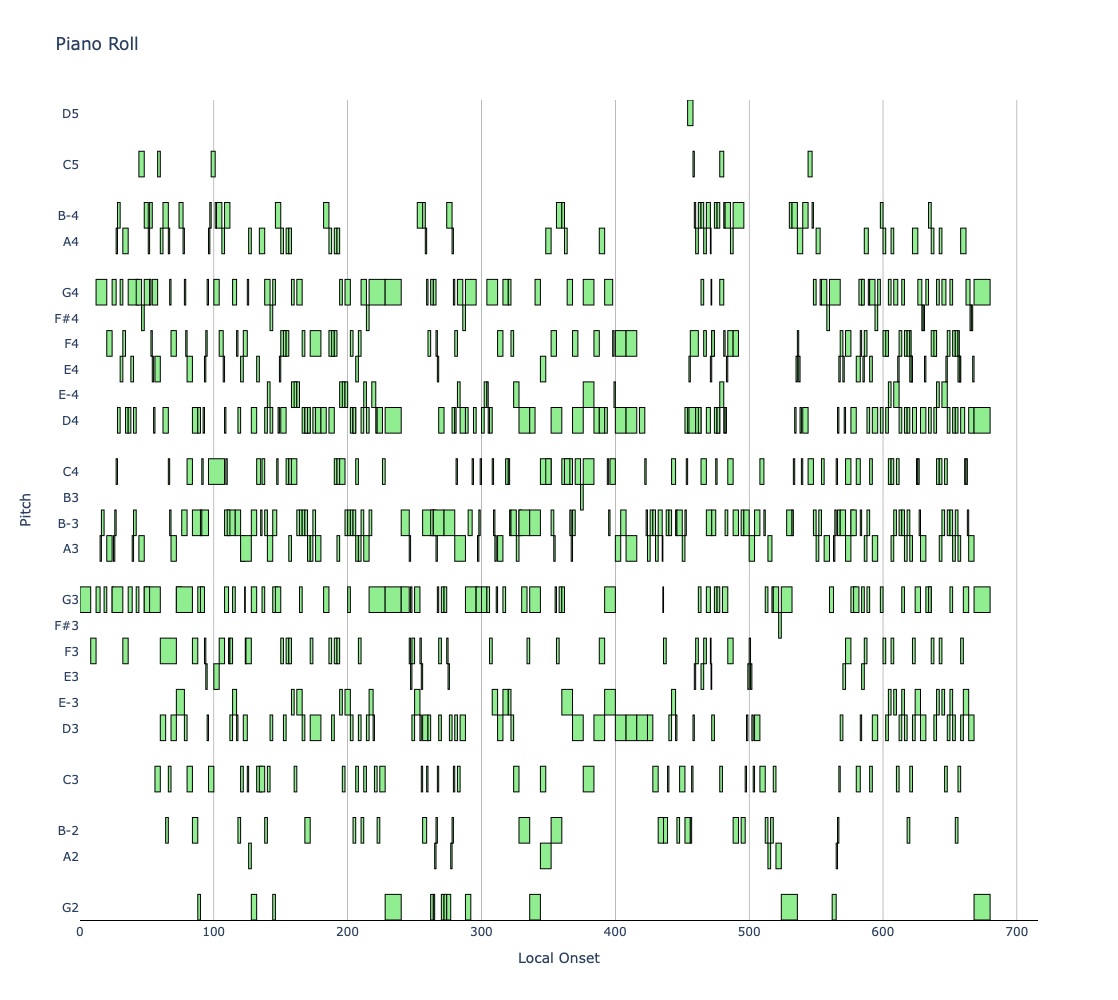

In [6]:
import pandas as pd
import plotly.graph_objects as go

def create_piano_roll_plotly(df):
    # Generate a consistent pitch name for each MIDI value to ensure matching tick labels
    midi_to_pitch = {midi: pitch for midi, pitch in zip(df['MIDI'], df['Pitch'])}

    # Create the figure object
    fig = go.Figure()

    # Create a single Bar trace for all notes
    fig.add_trace(go.Bar(
        x=df['Duration'],
        y=df['MIDI'],
        orientation='h',
        marker=dict(color='lightgreen', line=dict(color='black', width=1)),
        base=df['Local Onset'],
        width=1
    ))

    # Update the layout to use MIDI to pitch mapping for labeling
    fig.update_layout(
        title='Piano Roll',
        xaxis_title='Local Onset',
        yaxis_title='Pitch',
        yaxis=dict(
            tickmode='array',
            tickvals=list(midi_to_pitch.keys()),
            ticktext=list(midi_to_pitch.values())
        ),
        xaxis=dict(
            gridcolor='grey',
            gridwidth=0.5,
            linecolor='black',
            linewidth=1
        ),
        plot_bgcolor='white',
        showlegend=False,
        height=1000
    )

    # Show the figure
    fig.show()

create_piano_roll_plotly(df_processed)